# Self-Driving Car Engineer

## Lucas Gago

## Machine Learning

## Project: Vehicle Detection

In [45]:
import numpy as np
import cv2
import glob
import os
import pickle

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.image as mpimg


from scipy.ndimage.measurements import label
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import cv2
import glob
import glob
from time import time
from skimage.feature import hog
from sklearn.svm import LinearSVC
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from IPython.core.display import Image, display

%matplotlib inline

## Camera Calibration

---

In [2]:
def calibrate_camera(cal_images, nx, ny):
    imge=[]
    orig=[]
    objpoints=[]  # 3D points
    imgpoints=[]  # 2D points

    objp=np.zeros((nx*ny,3), np.float32)
    objp[:,:2]=np.mgrid[0:nx,0:ny].T.reshape(-1, 2)

    fname=cal_images[0]
    for fname in cal_images:
        img=cv2.imread(fname)
        gray=cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

        ret, corners=cv2.findChessboardCorners(gray, (nx, ny), None)
        if ret == True:
            objpoints.append(objp)
            imgpoints.append(corners)
            imge.append(cv2.drawChessboardCorners(img, (9,6), corners, ret))
            
    ret, mtx, dist, rvecs, tvecs=cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1],None,None)
    
    return mtx, dist,imge

In [3]:
def camera_setup():
    cal_images=glob.glob('camera_cal/calibration*.jpg')
    nx, ny=9, 6
    cam_mtx, cam_dist,imge= calibrate_camera(cal_images, nx, ny)
    return cam_mtx, cam_dist,imge

In [5]:
cam_mtx, cam_dist,imge= camera_setup()

## Load the dataset
---

In [7]:
cars_data = []
for filename in glob.glob('vehicles/*.png'):
    img=cv2.imread(filename)
    img=cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    cars_data.append(img)
    
non_cars_data = []
for filename in glob.glob('non_vehicles/*.png'):
    img=cv2.imread(filename)
    img=cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    non_cars_data.append(img)

### Train the model
---

In [15]:
def get_hog_features(img, orient, pix_per_cell, cell_per_block, vis=False, feature_vec=True):
    if vis == True:
        features, hog_image = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=False, 
                                  visualise=True, feature_vector=False)
        return features, hog_image
    else:      
        features = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=False, 
                       visualise=False, feature_vector=feature_vec)
        return features

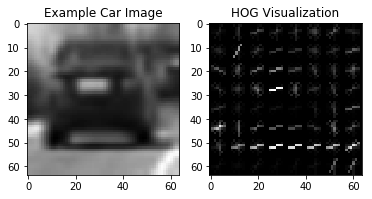

In [17]:
gray = cv2.cvtColor(cars_data[0], cv2.COLOR_RGB2GRAY)

orient = 9
pix_per_cell = 8
cell_per_block = 2

features, hog_image = get_hog_features(gray, orient, 
                        pix_per_cell, cell_per_block, 
                        vis=True, feature_vec=False)

fig = plt.figure()
plt.subplot(121)
plt.imshow(gray, cmap='gray')
plt.title('Example Car Image')
plt.subplot(122)
plt.imshow(hog_image, cmap='gray')
plt.title('HOG Visualization')

In [18]:
def extract_features(imgs, cspace='RGB', orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for image in imgs:
        if cspace != 'RGB':
            if cspace == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif cspace == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif cspace == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif cspace == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
            elif cspace == 'YCrCb':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
        else: feature_image = np.copy(image)      

        # Call get_hog_features() with vis=False, feature_vec=True
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=False, feature_vec=True))
            hog_features = np.ravel(hog_features)        
        else:
            hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, vis=False, feature_vec=True)
        # Append the new feature vector to the features list
        features.append(hog_features)
    # Return list of feature vectors
    return features

In [22]:
colorspace = 'YCrCb' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 7
pix_per_cell = 8
cell_per_block = 2
hog_channel = "ALL" # Can be 0, 1, 2, or "ALL"

sample_size = 2400
cars= cars_data[0:sample_size]
non_cars = non_cars_data[0:sample_size]

t=time.time()
car_features = extract_features(cars, cspace=colorspace, orient=orient, 
                        pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, 
                        hog_channel=hog_channel)
notcar_features = extract_features(non_cars, cspace=colorspace, orient=orient, 
                        pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, 
                        hog_channel=hog_channel)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to extract HOG features...')
# Create an array stack of feature vectors
X = np.vstack((car_features, notcar_features)).astype(np.float64)                        
# Fit a per-column scaler
X_scaler = StandardScaler().fit(X)
# Apply the scaler to X
scaled_X = X_scaler.transform(X)

# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))


# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(
    scaled_X, y, test_size=0.2, random_state=rand_state)

print('Using:',orient,'orientations',pix_per_cell,
    'pixels per cell and', cell_per_block,'cells per block')
print('Feature vector length:', len(X_train[0]))
# Use a linear SVC 
svc = LinearSVC()
# Check the training time for the SVC
t=time.time()
svc.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')
# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))
# Check the prediction time for a single sample
t=time.time()
n_predict = 10
print('My SVC predicts: ', svc.predict(X_test[0:n_predict]))
print('For these',n_predict, 'labels: ', y_test[0:n_predict])
t2 = time.time()
print(round(t2-t, 5), 'Seconds to predict', n_predict,'labels with SVC')

4.57 Seconds to extract HOG features...
Using: 7 orientations 8 pixels per cell and 2 cells per block
Feature vector length: 4116
0.15 Seconds to train SVC...
Test Accuracy of SVC =  1.0
My SVC predicts:  [ 1.  1.  1.  0.  0.  0.  0.  0.  0.  1.]
For these 10 labels:  [ 1.  1.  1.  0.  0.  0.  0.  0.  0.  1.]
0.0015 Seconds to predict 10 labels with SVC


In [23]:


import numpy
import pandas
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

Using TensorFlow backend.


In [24]:
# fix random seed for reproducibility
seed = 7
numpy.random.seed(seed)

In [38]:
# baseline model
def create_baseline():
    # create model
    model = Sequential()
    model.add(Dense(60, input_dim=4116, init='normal', activation='relu'))
    model.add(Dense(1, init='normal', activation='sigmoid'))
    # Compile model
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

In [ ]:
# evaluate model with standardized dataset
estimator = KerasClassifier(build_fn=create_baseline, nb_epoch=100, batch_size=5, verbose=0)
kfold = StratifiedKFold(n_splits=1, shuffle=True, random_state=seed)
results = cross_val_score(estimator, X_train, y_train, cv=kfold)
print("Results: %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100))

In [43]:
def train_classifier(clf, X_train, y_train):
    ''' Fits a classifier to the training data. '''
    
    # Start the clock, train the classifier, then stop the clock
    start = time()
    clf.fit(X_train, y_train)
    end = time()
    
    # Print the results
    print ("Trained model in {:.4f} seconds".format(end - start))

def predict_labels_accuracy(clf, features, target):
    ''' Makes predictions using a fit classifier based on the accuracy score. '''
    
    y_pred = clf.predict(features)
    
    # Print and return results
    return accuracy_score(target, y_pred)   

def train_predict(clf, X_train, y_train, X_test, y_test):
    ''' Train and predict using a classifer based on F1 score. '''
    
    # Indicate the classifier and the training set size
    print ("Training a {} using a training set size of {}. . .".format(clf.__class__.__name__, len(X_train)))
    
    # Train the classifier
    train_classifier(clf, X_train, y_train)
    
    # Print the results of prediction for both training and testing
    print ("Accuracy score for training set: {:.4f}.".format(predict_labels_accuracy(clf, X_train, y_train)))
    print ("Accuracy score for test set: {:.4f}.".format(predict_labels_accuracy(clf, X_test, y_test)))

In [49]:
# Import  three supervised learning models from sklearn
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score



# Initialize the three models
clf_A = DecisionTreeClassifier(random_state=1)
clf_B = GaussianNB()
clf_C = SVC(random_state=2)


# Execute the 'train_predict' function for each classifier and each training set size

# loop thru models, then thru train sizes
for clf in [clf_A, clf_B, clf_C]:
    print ("\n{}: \n".format(clf.__class__.__name__))
    for n in [100,250,500]:
        train_predict(clf, X_train[:n], y_train[:n], X_test, y_test)
        print ('-'*32)


DecisionTreeClassifier: 

Training a DecisionTreeClassifier using a training set size of 100. . .
Trained model in 0.0940 seconds
Accuracy score for training set: 1.0000.
Accuracy score for test set: 0.8050.
--------------------------------
Training a DecisionTreeClassifier using a training set size of 250. . .
Trained model in 0.3585 seconds
Accuracy score for training set: 1.0000.
Accuracy score for test set: 0.8500.
--------------------------------
Training a DecisionTreeClassifier using a training set size of 500. . .
Trained model in 0.9270 seconds
Accuracy score for training set: 1.0000.
Accuracy score for test set: 0.8300.
--------------------------------

GaussianNB: 

Training a GaussianNB using a training set size of 100. . .
Trained model in 0.0095 seconds
Accuracy score for training set: 1.0000.
Accuracy score for test set: 0.9250.
--------------------------------
Training a GaussianNB using a training set size of 250. . .
Trained model in 0.0470 seconds
Accuracy score for

In [52]:
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_moons, make_circles, make_classification
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis



names = ["Nearest Neighbors", "Linear SVM", "RBF SVM", "Gaussian Process",
         "Decision Tree", "Random Forest", "Neural Net", "AdaBoost",
         "Naive Bayes", "QDA"]

classifiers = [
    KNeighborsClassifier(3),
    SVC(kernel="linear", C=0.025),
    SVC(gamma=2, C=1),
    GaussianProcessClassifier(1.0 * RBF(1.0), warm_start=True),
    DecisionTreeClassifier(max_depth=5),
    RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1),
    MLPClassifier(alpha=1),
    AdaBoostClassifier(),
    GaussianNB(),
    QuadraticDiscriminantAnalysis()]

for clf in classifiers:
    print ("\n{}: \n".format(clf.__class__.__name__))
    for n in [100,250,500]:
        train_predict(clf, X_train[:n], y_train[:n], X_test, y_test)
        print ('-'*32)


KNeighborsClassifier: 

Training a KNeighborsClassifier using a training set size of 100. . .
Trained model in 0.0185 seconds
Accuracy score for training set: 0.9300.
Accuracy score for test set: 0.8200.
--------------------------------
Training a KNeighborsClassifier using a training set size of 250. . .
Trained model in 0.0300 seconds
Accuracy score for training set: 0.9440.
Accuracy score for test set: 0.9050.
--------------------------------
Training a KNeighborsClassifier using a training set size of 500. . .
Trained model in 0.0715 seconds
Accuracy score for training set: 0.9700.
Accuracy score for test set: 0.9700.
--------------------------------

SVC: 

Training a SVC using a training set size of 100. . .
Trained model in 0.0650 seconds
Accuracy score for training set: 1.0000.
Accuracy score for test set: 0.9900.
--------------------------------
Training a SVC using a training set size of 250. . .
Trained model in 0.3580 seconds
Accuracy score for training set: 1.0000.
Accura

C:\Users\gagol\Miniconda3\envs\carnd-term1\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:563: ConvergenceWarning: Stochastic Optimizer: Maximum iterations reached and the optimization hasn't converged yet.
  % (), ConvergenceWarning)


Trained model in 7.7995 seconds
Accuracy score for training set: 1.0000.
Accuracy score for test set: 0.9950.
--------------------------------
Training a MLPClassifier using a training set size of 250. . .
Trained model in 8.2810 seconds
Accuracy score for training set: 1.0000.
Accuracy score for test set: 0.9950.
--------------------------------
Training a MLPClassifier using a training set size of 500. . .
Trained model in 10.5720 seconds
Accuracy score for training set: 1.0000.
Accuracy score for test set: 1.0000.
--------------------------------

AdaBoostClassifier: 

Training a AdaBoostClassifier using a training set size of 100. . .
Trained model in 2.0350 seconds
Accuracy score for training set: 1.0000.
Accuracy score for test set: 0.9450.
--------------------------------
Training a AdaBoostClassifier using a training set size of 250. . .
Trained model in 5.0846 seconds
Accuracy score for training set: 1.0000.
Accuracy score for test set: 0.9800.
--------------------------------

C:\Users\gagol\Miniconda3\envs\carnd-term1\lib\site-packages\sklearn\discriminant_analysis.py:695: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


Trained model in 0.0785 seconds
Accuracy score for training set: 1.0000.
Accuracy score for test set: 0.5100.
--------------------------------
Training a QuadraticDiscriminantAnalysis using a training set size of 250. . .
Trained model in 0.0705 seconds
Accuracy score for training set: 1.0000.
Accuracy score for test set: 0.5750.
--------------------------------
Training a QuadraticDiscriminantAnalysis using a training set size of 500. . .
Trained model in 0.1975 seconds
Accuracy score for training set: 1.0000.
Accuracy score for test set: 0.6000.
--------------------------------


In [56]:
# Optimize the SVM parameters by using grid search cross validation

# Import 'GridSearchCV' and 'make_scorer'
from sklearn.grid_search import GridSearchCV
from sklearn.metrics import make_scorer

# Create the parameters list you wish to tune

#parameters = {'kernel':('linear', 'rbf','sigmoid'), 'C':[1,2,3,4,5,6,7,8,9,10,11,12,13,14,15], 
#              'gamma':[.000001,.000005,.00005,.0005,.001,.005,.01,.02,.04,.05,.1,.3,.5]}
parameters = {'kernel':('linear', 'rbf','sigmoid'), 'C':[1,5,10,15], 
              'gamma':[.000005,.001,.04,.5]}

# Initialize the classifier
clf = SVC(random_state=3)

# Perform grid search on the classifier using the default scoring method (accuracy)
grid_obj = GridSearchCV(clf, parameters)

# Fit the grid search object to the training data and find the optimal parameters
grid_obj.fit(X_train[:100],y_train[:100])

# Get the estimator
clf = grid_obj.best_estimator_

# Report the final F1 score for training and testing after parameter tuning
print ("Tuned model has a training accuracy score of {:.4f}.".format(predict_labels_accuracy(clf, X_train, y_train)))
print ("Tuned model has a testing accuracy score of {:.4f}.".format(predict_labels_accuracy(clf, X_test, y_test)))

print("The best parameters are %s"
      % (grid_obj.best_params_))

# Output predictions for further analysis
np.savetxt("eval-SVM.csv", clf.predict(X_test), delimiter=",")

Tuned model has a training accuracy score of 0.9962.
Tuned model has a testing accuracy score of 0.9900.
The best parameters are {'gamma': 5e-06, 'C': 1, 'kernel': 'linear'}
